In [61]:
import torchvision.transforms as T
import torch
import torch.nn.functional as F
import itertools
import matplotlib.pyplot as plt


def l2_dist_attn(q, k, scale=100.0):
    # not currently working as intended
    diffs = (q[:,None] - k[:,:,None]).norm(dim=-1) * scale
    diffs = diffs + torch.eye(diffs.size(-1)).to(diffs.device) * 1e4 # avoid self
    weights = torch.nn.functional.softmax(-diffs, dim=-1)
    output = weights @ data

    return output


# segmentation task, using attention as a "consensus algorithm"
points_map = [
    (600, (1,1)),
    (600, (0,-1)),
    (600, (-1,1)),
]

all_points = []
for num_points, offset in points_map:
    tensor = torch.randn(1, num_points, 10).cuda()
    tensor[:, :, :2] += torch.tensor(offset).cuda()
    all_points.append(tensor)

tensor = torch.cat(all_points, dim=1)

# Move tensor to CPU and get first 2 dimensions for visualization
orig_points = tensor[0, :, :2].cpu().numpy()


In [62]:
steps = 100
step_size = 0.85
scale = 10.0
do_attention = True

with torch.no_grad():
    for i in range(steps):
        if do_attention:
            q = k = F.normalize(tensor, dim=-1)
            output = F.scaled_dot_product_attention(q, k, tensor, scale=scale)
        else:
            output = l2_dist_attn(tensor, tensor, scale=scale)

        tensor = tensor * (1-step_size) + output * step_size

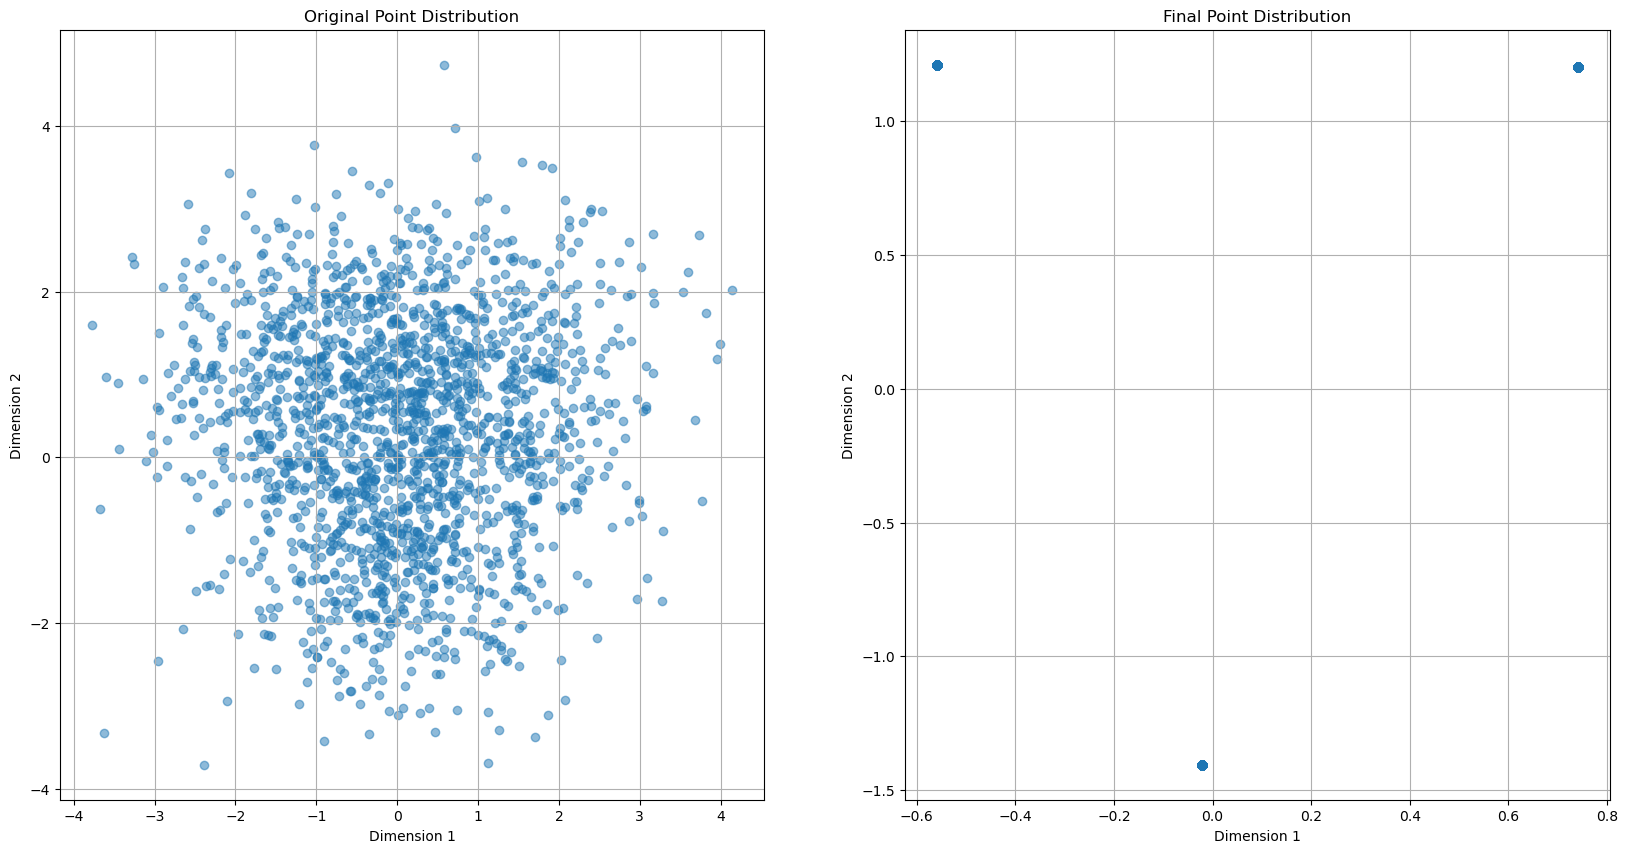

In [63]:
# Move tensor to CPU and get first 2 dimensions for visualization
points = tensor[0, :, :2].cpu().numpy()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(orig_points[:, 0], orig_points[:, 1], alpha=0.5)
ax1.set_title('Original Point Distribution')
ax1.set_xlabel('Dimension 1')
ax1.set_ylabel('Dimension 2')
ax1.grid(True)

ax2.scatter(points[:, 0], points[:, 1], alpha=0.5)
ax2.set_title('Final Point Distribution')
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
ax2.grid(True)

plt.show()
